# Evaluation of the spikefinder challenge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
data = pd.read_csv('spikefinder.csv')
data= data.drop(['algo___v','Unnamed: 0','algo__id','dset__id','label__id', 'algo_repository'],1)

Check if dataset contains any submissions after the deadline

In [3]:
np.any(data['algo_timestamp'] > '2017-05-05 00:00:00.0')

False

Filter results for test data and correlation as measure only

In [4]:
data_test = data.loc[data['dset_dataset'].str.contains('test')]
data_test = data_test.loc[data_test['label_label']=='corr']

data_train = data.loc[data['dset_dataset'].str.contains('1.train|2.train|3.train|4.train|5.train')]
data_train = data_train.loc[data_train['label_label']=='corr']

Create a nice dataframe to work with

In [5]:
def weighted_mean(x,w):
    return np.sum(w * x)/np.sum(w)

entries = np.unique(data_test['algo_timestamp'])

test_mean = np.zeros_like(entries)
test_wmean = test_mean.copy()
train_mean = np.zeros_like(entries)
train_wmean = test_mean.copy()

algo = test_mean.copy()
submitter = test_mean.copy()
days = test_mean.copy()

w_test = [5, 10, 6, 3, 8]
w_train = [11, 20, 12, 6, 9]

start_date = pd.to_datetime('2016-11-01 00:00:00.0')

for i, date in enumerate(entries):
    df_test = data_test[data_test['algo_timestamp']==date].reset_index()
    df_train = data_train[data_train['algo_timestamp']==date].reset_index()

    scores = df_test['label_value'].as_matrix()
    test_mean[i] = np.mean(scores)
    test_wmean[i] = weighted_mean(scores,w_test)
    
    scores = df_train['label_value'].as_matrix()
    train_mean[i] = np.mean(scores)
    train_wmean[i] = weighted_mean(scores,w_train)
    
    algo[i] = df_test.loc[0,'algo_algorithm']
    
    submitter[i] = df_test.loc[0,'algo_name']
    
    days[i] = (pd.to_datetime(df_test.loc[0,'algo_timestamp'])-start_date).days
    
    
spikefinder = pd.DataFrame({'algo': algo,
                            'submitter': submitter,
                            'test_mean': test_mean,
                            'test_wmean': test_wmean,
                            'train_mean': train_mean,
                            'train_wmean': train_wmean,
                            'date': entries,
                            'days': days})

spikefinder = spikefinder.drop_duplicates(subset=['test_mean','submitter'])

stm = spikefinder.loc[spikefinder['algo']=='stm','test_mean'].as_matrix()
spikefinder['delta_stm'] = (spikefinder['test_mean'] - stm)

# one submission reports a training correlation of 1 - likely submitted original spike trains
spikefinder = spikefinder[spikefinder['train_mean']!=1]

# fix for filtering unique submitters
spikefinder.loc[spikefinder['submitter']==
                'Stephan Gerhard, Peter Rupprecht','submitter'] = 'Peter Rupprecht, Stephan Gerhard' 



### Top ten by test error

In [6]:
spikefinder.sort_values(by='test_mean',ascending=False).head(10)


,algo,date,days,submitter,test_mean,test_wmean,train_mean,train_wmean,delta_stm
43,Purgatorio,2017-05-02 02:33:43.187,182,Patrick Mineault,0.464457,0.461653,0.58074,0.570199,0.0769593
52,convi6,2017-05-04 12:59:26.058,184,Nikolay,0.461296,0.461945,0.51327,0.504478,0.0737989
47,Embedding of CNNs via Ca recording stats,2017-05-02 07:56:05.626,182,"Peter Rupprecht, Stephan Gerhard",0.460598,0.461709,0.528088,0.51411,0.0731003
23,SpikeNet-3,2017-04-18 08:49:32.462,168,Thomas McColgan,0.455694,0.455387,0.511553,0.501417,0.0681964
8,MLspike,2017-02-23 15:18:17.677,114,Thomas Deneux,0.455631,0.459057,0.533527,0.526033,0.0681337
34,MLspike (autocalibration of noise for some dat...,2017-04-28 11:58:51.575,178,Thomas Deneux,0.454978,0.456862,0.537784,0.528465,0.0674801
38,DeepSpike (Fully Supervised),2017-05-01 22:58:32.331,181,Artur Speiser,0.454813,0.460792,0.503557,0.495718,0.0673159
49,"MLspike (optimize median, noise autocalibration)",2017-05-02 15:16:58.097,182,Thomas Deneux,0.453767,0.454553,0.552501,0.545296,0.0662699
51,convi3,2017-05-03 14:50:27.558,183,Nikolay,0.453582,0.457679,0.506875,0.497032,0.0660843
48,MLspike (optimize median),2017-05-02 15:12:48.948,182,Thomas Deneux,0.450482,0.451813,0.548677,0.542344,0.0629846


Top ten by weighted test error

In [8]:
# top 5 by weighted test error
spikefinder.sort_values(by='test_wmean',ascending=False).head()


,algo,date,days,submitter,test_mean,test_wmean,train_mean,train_wmean,delta_stm
52,convi6,2017-05-04 12:59:26.058,184,Nikolay,0.461296,0.461945,0.51327,0.504478,0.0737989
47,Embedding of CNNs via Ca recording stats,2017-05-02 07:56:05.626,182,"Peter Rupprecht, Stephan Gerhard",0.460598,0.461709,0.528088,0.51411,0.0731003
43,Purgatorio,2017-05-02 02:33:43.187,182,Patrick Mineault,0.464457,0.461653,0.58074,0.570199,0.0769593
38,DeepSpike (Fully Supervised),2017-05-01 22:58:32.331,181,Artur Speiser,0.454813,0.460792,0.503557,0.495718,0.0673159
8,MLspike,2017-02-23 15:18:17.677,114,Thomas Deneux,0.455631,0.459057,0.533527,0.526033,0.0681337


### All submissions qualifying for paper

Per submitter, the best submission qualifies. All submissions with a `test_mean` greater than `stm` qualify.

In [9]:
spikefinder_unique = spikefinder.sort_values(by='test_mean',ascending=False).reset_index().drop(['index'],1)

spikefinder_unique = spikefinder_unique.drop_duplicates(subset='submitter')

spikefinder_unique[spikefinder_unique['delta_stm']>0]


,algo,date,days,submitter,test_mean,test_wmean,train_mean,train_wmean,delta_stm
0,Purgatorio,2017-05-02 02:33:43.187,182,Patrick Mineault,0.464457,0.461653,0.58074,0.570199,0.0769593
1,convi6,2017-05-04 12:59:26.058,184,Nikolay,0.461296,0.461945,0.51327,0.504478,0.0737989
2,Embedding of CNNs via Ca recording stats,2017-05-02 07:56:05.626,182,"Peter Rupprecht, Stephan Gerhard",0.460598,0.461709,0.528088,0.51411,0.0731003
3,SpikeNet-3,2017-04-18 08:49:32.462,168,Thomas McColgan,0.455694,0.455387,0.511553,0.501417,0.0681964
4,MLspike,2017-02-23 15:18:17.677,114,Thomas Deneux,0.455631,0.459057,0.533527,0.526033,0.0681337
6,DeepSpike (Fully Supervised),2017-05-01 22:58:32.331,181,Artur Speiser,0.454813,0.460792,0.503557,0.495718,0.0673159
11,linear gaussian,2017-05-02 00:51:29.385,182,johannes,0.441689,0.437386,0.519541,0.513403,0.0541916
14,Vanilla_0.1a,2017-03-23 18:30:50.419,142,Dario Ringach,0.428483,0.425476,0.48377,0.474737,0.0409861
15,Suite2p,2016-12-04 19:15:26.173,33,marius10p,0.423142,0.428679,0.467852,0.471965,0.035645
17,1D ConvNet with a bunch of features,2017-03-02 04:18:15.017,121,Ben Bolte and Chi Le,0.419496,0.416914,0.512118,0.506926,0.0319989


### Plots

(0, 0.6)

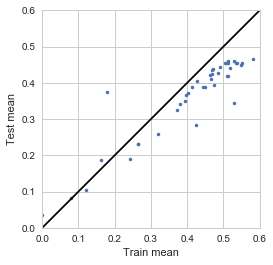

In [10]:
plt.subplot(1,1,1,aspect='equal')
plt.plot(spikefinder['train_mean'],spikefinder['test_mean'],'.')
plt.plot([0,1],[0,1],'k')
plt.xlabel('Train mean')
plt.ylabel('Test mean')
plt.xlim([0, .6])
plt.ylim([0, .6])


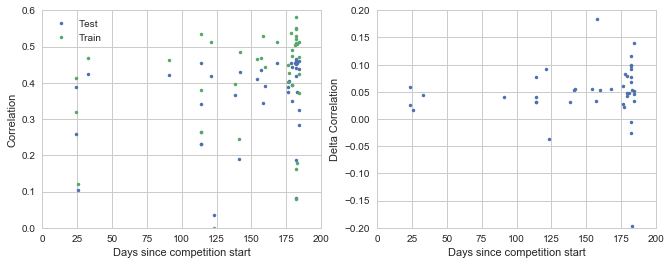

In [11]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.plot(spikefinder['days'],spikefinder['test_mean'],'.')
plt.plot(spikefinder['days'],spikefinder['train_mean'],'.')
plt.xlim([0,200])
plt.ylim([0,.6])
plt.xlabel('Days since competition start')
plt.ylabel('Correlation')
plt.legend(['Test','Train'])

plt.subplot(1,2,2)
delta = spikefinder['train_mean'] - spikefinder['test_mean']
plt.plot(spikefinder['days'],delta,'.')
plt.xlim([0,200])
plt.ylim([-.2,.2])
plt.xlabel('Days since competition start')
plt.ylabel('Delta Correlation')

In [12]:
np.unique(data_test["algo_contact"])

array(['@freeman-lab', '@phreeza', 'arturspeiser@googlemail.com',
       'codekansas', 'dario@ucla.edu', 'haslacherdavid@gmail.com',
       'https://github.com/PTRRupprecht/SpikefinderCompetition2017',
       'j-friedrich', 'katsu1110', 'kazemipoura@janelia.hhmi.org',
       'kleskjr@gmail.com', 'marius10p', 'nikolay.chenkov@bccn-berlin.de',
       'nikolay@bccn-berlin.de', 'patrick.mineault@gmail.com',
       'patrickmineault', 'peter.rupprecht@fmi.ch',
       'philipp.berens@uni-tuebingen.de', 'phreeza',
       'thomas.deneux@unic.cnr-gif.fr', 'thomas.deneux@unic.cnrs-gif.fr',
       'thomas.mccolgan@gmail.com', 'tim.machado@gmail.com',
       'vcalderon@email.ifc.unam.mx'], dtype=object)

In [10]:
spikefinder.to_csv('data/submissions_22_06_17.csv', encoding='utf-8')


In [14]:
spikefinder_unique

,algo,date,days,submitter,test_mean,test_wmean,train_mean,train_wmean,delta_stm
0,Purgatorio,2017-05-02 02:33:43.187,182,Patrick Mineault,0.464457,0.461653,0.58074,0.570199,0.0769593
1,convi6,2017-05-04 12:59:26.058,184,Nikolay,0.461296,0.461945,0.51327,0.504478,0.0737989
2,Embedding of CNNs via Ca recording stats,2017-05-02 07:56:05.626,182,"Peter Rupprecht, Stephan Gerhard",0.460598,0.461709,0.528088,0.51411,0.0731003
3,SpikeNet-3,2017-04-18 08:49:32.462,168,Thomas McColgan,0.455694,0.455387,0.511553,0.501417,0.0681964
4,MLspike,2017-02-23 15:18:17.677,114,Thomas Deneux,0.455631,0.459057,0.533527,0.526033,0.0681337
6,DeepSpike (Fully Supervised),2017-05-01 22:58:32.331,181,Artur Speiser,0.454813,0.460792,0.503557,0.495718,0.0673159
11,linear gaussian,2017-05-02 00:51:29.385,182,johannes,0.441689,0.437386,0.519541,0.513403,0.0541916
14,Vanilla_0.1a,2017-03-23 18:30:50.419,142,Dario Ringach,0.428483,0.425476,0.48377,0.474737,0.0409861
15,Suite2p,2016-12-04 19:15:26.173,33,marius10p,0.423142,0.428679,0.467852,0.471965,0.035645
17,1D ConvNet with a bunch of features,2017-03-02 04:18:15.017,121,Ben Bolte and Chi Le,0.419496,0.416914,0.512118,0.506926,0.0319989


In [15]:
spikefinder_unique

,algo,date,days,submitter,test_mean,test_wmean,train_mean,train_wmean,delta_stm
0,Purgatorio,2017-05-02 02:33:43.187,182,Patrick Mineault,0.464457,0.461653,0.58074,0.570199,0.0769593
1,convi6,2017-05-04 12:59:26.058,184,Nikolay,0.461296,0.461945,0.51327,0.504478,0.0737989
2,Embedding of CNNs via Ca recording stats,2017-05-02 07:56:05.626,182,"Peter Rupprecht, Stephan Gerhard",0.460598,0.461709,0.528088,0.51411,0.0731003
3,SpikeNet-3,2017-04-18 08:49:32.462,168,Thomas McColgan,0.455694,0.455387,0.511553,0.501417,0.0681964
4,MLspike,2017-02-23 15:18:17.677,114,Thomas Deneux,0.455631,0.459057,0.533527,0.526033,0.0681337
6,DeepSpike (Fully Supervised),2017-05-01 22:58:32.331,181,Artur Speiser,0.454813,0.460792,0.503557,0.495718,0.0673159
11,linear gaussian,2017-05-02 00:51:29.385,182,johannes,0.441689,0.437386,0.519541,0.513403,0.0541916
14,Vanilla_0.1a,2017-03-23 18:30:50.419,142,Dario Ringach,0.428483,0.425476,0.48377,0.474737,0.0409861
15,Suite2p,2016-12-04 19:15:26.173,33,marius10p,0.423142,0.428679,0.467852,0.471965,0.035645
17,1D ConvNet with a bunch of features,2017-03-02 04:18:15.017,121,Ben Bolte and Chi Le,0.419496,0.416914,0.512118,0.506926,0.0319989


In [16]:
spikefinder_unique.to_csv('spikefinder_unique.csv')